In [3]:
# default_exp data.load_pd

In [4]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [5]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [6]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [7]:
# export
import numpy as np
import pandas as pd

In [8]:
# export
class TSMulti(MultiTuple):pass

## Transform catagorical data

In [9]:
# export
class TensorCatI(TensorBase):pass

class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            self.vocab[i], self.o2i[i] = uniqueify(list(df[col]), sort=True, bidir=True)
            
    def encodes(self, o:TensorCat):
        r = []
        for i in self.o2i:
            r.append(self.o2i[i][o.o[i]])            
        return TensorCatI(r, label = o._meta['label'])
    
    def decodes(self, o:TensorCatI): 
        r = []
        for i_cat in self.vocab:
            r.append(self.vocab[i_cat][o[i_cat]])
        return TensorCat(r, label = o._meta.get('label',None))
    
    

In [10]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a']))
test_eq(tmf.decode(o_tmf),TensorCat(['a']))

In [11]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b']))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b']))

In [12]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [13]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatMultiTfm(df,'a')
print(tmf)
o = TSMulti(TensorBase([1]), TensorCat('a'))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0])) )
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

CatMultiTfm: True (TSMulti,object) -> encodes (TSMulti_,object) -> decodes


# Dataloader

In [200]:
def get_df():
    return pd.DataFrame(data={'x':[np.arange(100.),
                           np.arange(120.)],
                   'ts_0':[np.ones(100)[None,:],
                           np.ones(120)[None,:]],
                   'ts_1':[pd.Series(np.arange(100)+np.random.randn(100)),
                           pd.Series(np.arange(120)+np.random.randn(120))],
                   'var_0':[0.,1.],
                   'var_1':[2.,1.5],
                   'con_0':['a','b'],
                   'con_1':['d','c']
                       })
df = get_df()
df

,x,ts_0,ts_1,var_0,var_1,con_0,con_1
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","0 0.070345 1 2.441638 2 1.269778 3 2.132209 4 3.690921 ... 95 96.152542 96 97.829102 97 96.513450 98 96.551966 99 99.431034 Length: 100, dtype: float64",0.0,2.0,a,d
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, ...]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]]","0 0.746209 1 0.108774 2 3.177584 3 2.574249 4 3.901511 ... 115 116.979744 116 115.629440 117 118.776147 118 119.120568 119 117.556871 Length: 120, dtype: float64",1.0,1.5,b,c


In [201]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [202]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [203]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [204]:
# export
def reconize_cols(dataset):
    con_names, cat_names, ts_names, classes = L(), L(), L(), {}
    for col in dataset.columns:
        t = type(dataset[col].iloc[0])
        if t is pd.core.series.Series:
            ts_names.append(col)
        elif t is np.ndarray:
            o = arrays2series(dataset[col])
            dataset[col] = o
            ts_names.append(col)
        elif isinstance(dataset[col].iloc[0], str):
            cat_names.append(col)
            classes[col] = uniqueify(list(dataset[col].values))
        elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
            con_names.append(col)
        else:
            raise Exception(t)
    return con_names, cat_names, ts_names, classes, dataset

In [318]:
# export
class PrepDF(TabularProc):
    def setup(self, dl, train_setup):
        # speed up retrival
        dl.con = dl.dataset.loc[:,dl.con_names].values.astype(float)
        dl.cat = [list(dl.dataset.loc[i,dl.cat_names]) for i in range(dl.dataset.shape[0])]
        if len(dl.ts_names):
            dl.tsx = [np.concatenate([o[None,:] for o in dl.dataset.loc[i,dl.ts_names].values]) for i in range(dl.dataset.shape[0])]
        else:
            dl.tsx = [np.empty([0,0]) for i in range(dl.dataset.shape[0])]
        assert len(dl.cat) == len(dl.tsx) == dl.con.shape[0]
        return dl

In [320]:
class test_dl(TfmdDL):    
    def __init__(self, dataset:pd.DataFrame, y_name ):
        self.con_names, self.cat_names, self.ts_names, self.classes, self.dataset = reconize_cols(dataset)     
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        PrepDF().setup(self, True)        
df = get_df()

dl = test_dl(df, 'x')
test_eq(dl.cat,[['a', 'd'], ['b', 'c']])
test_eq(dl.con.shape,(2,2))
test_eq(dl.tsx[0].shape, [2,100])

In [342]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1,
                 min_seq_len=None, norm=True,procs = None, **kwargs):
        store_attr(self,'horizon,lookback,step,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names, self.classes, dataset = reconize_cols(dataset)        
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        n = self.make_ids()
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(dataset, self.cat_names))
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(L(procs) + PrepDF(), as_item=True)
        self.procs.setup(self)
            

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        y = get_part_of_ts(self.dataset.loc[ts_id, self.y_name].values[None,:], lookback_id, self.lookback + self.horizon,
                           t = TensorSeqs, label=[self.y_name + '_y'], m=['g'])
        x = TensorSeqs(y[:,:self.lookback], label=[self.y_name + '_x'], m=['g'])
        if len(dl.ts_names):
            tsx = get_part_of_ts(self.tsx[ts_id], lookback_id, self.lookback + self.horizon,
                                 t = TensorSeqs, label=self.ts_names)
        else: tsx = TensorSeqs(np.empty([0]), label=self.ts_names)
        r = [x, tsx]
        r.append(TensorCat(self.cat[ts_id], label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(self.con[ts_id,:], label=self.con_names))            
        # TODO make y its own type
        r.append(y)
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx) 
        return TSMulti(r)    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [343]:
df

,x,ts_0,ts_1,var_0,var_1,con_0,con_1
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","0 0.848117 1 -0.282084 2 2.840582 3 2.331707 4 3.539616 ... 95 93.720156 96 96.180007 97 96.996114 98 97.477593 99 97.457289 Length: 100, dtype: float64",0.0,2.0,a,d
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, ...]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]]","0 -0.839189 1 1.975307 2 1.782887 3 4.128263 4 4.760819 ... 115 115.995611 116 115.703299 117 116.342949 118 119.371497 119 120.083166 Length: 120, dtype: float64",1.0,1.5,b,c


In [344]:
tsx = df.loc[:,['var_0', 'var_1']].values.astype(float)

In [345]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, num_workers=0)
def get_all():
    for o in dl:
        pass
import time
st = time.time()
get_all()
tot_time = time.time()-st
test_eq(tot_time<.6, True)
print(tot_time)

0.16157793998718262


In [346]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break
dl.classes['cat_0'] = L('a','b')

In [347]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [348]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','var_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    
test_eq(first(dl), dl.one_batch())

In [349]:
# hide
# test self.new
dl.new()

# Showing

In [350]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [351]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [352]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

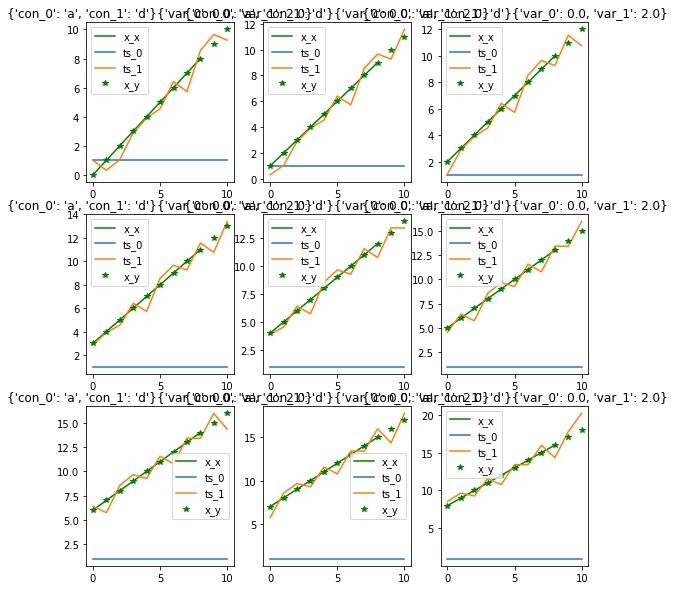

In [353]:
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

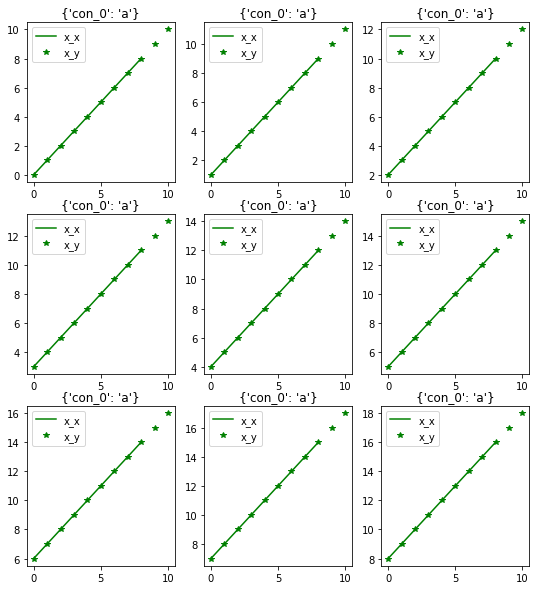

In [354]:
# hide
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [355]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [356]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [357]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [358]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,29657784.0,11205198848.0,'00:00']


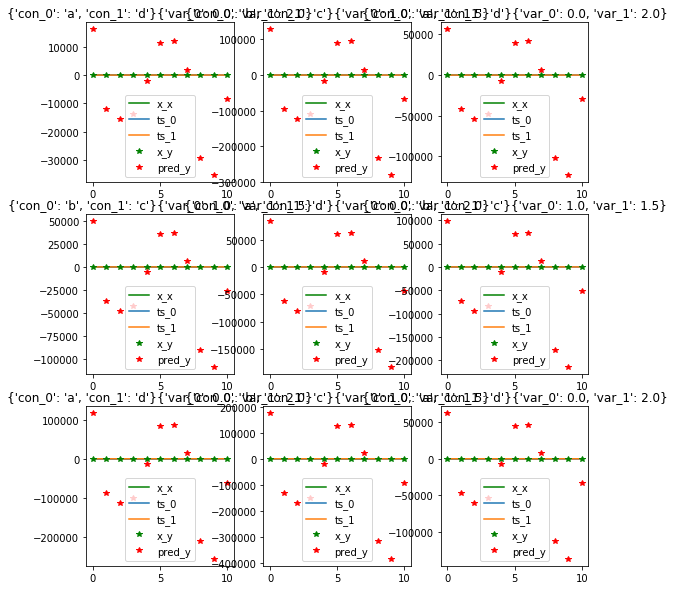

In [359]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

(#4) [0,21874916.0,8265383936.0,'00:00']


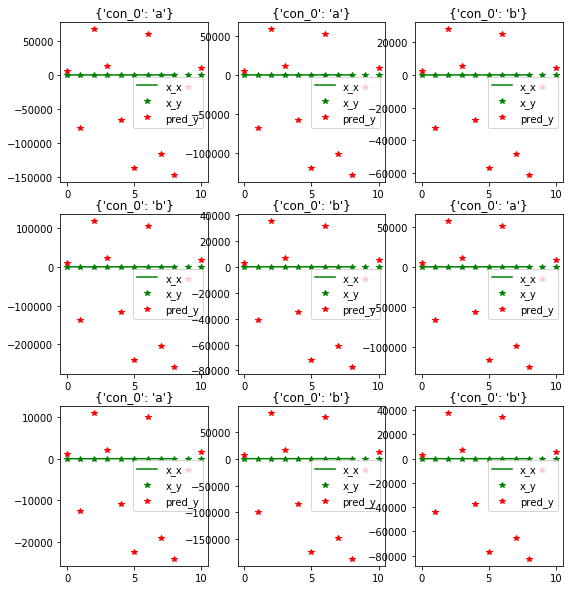

In [360]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [361]:
from fastseq.data.external import *

In [362]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city'] = df['city']
df.head()

,x,weather,city,cont
0,"[[1.816818358537503, 1.6695091876857877, 1.317362062158074, 1.460325639667649, 1.1742179309333935, 1.2365180804533038, 0.748057357105933, 0.6139754716973093, 0.42922492834759324, 0.21156643405354061, -0.12066138252541302, -0.5915072394642134, -0.5792810616025167, -0.3908410573281261, -0.09038836970466552, 0.43920227837030307, 0.46556331636790144, 0.646460519070598, 0.710660345320703, 0.74440010810065, 0.23655708892115923, -0.19983366685831697, -1.1393991438433164, -1.4449474369834852, -1.3893575043878406, -1.5790315298100197, -1.4135445274747196, -1.4414302332386693, -1.151213023206178, -0...","[[7.544339059248789, 6.832108713630148, 7.285256354958695, 8.78464979252096, 9.651315196344328, 8.900978971888497, 7.56963073659115, 7.284219121007342, 8.053315539543938, 8.324221151358, 7.215674642255421, 5.8256034421276155, 5.791109915630165, 7.077379460047643, 8.042289302701969, 7.684578493056226, 7.544339059248789, 6.832108713630148, 7.285256354958695, 8.78464979252096, 9.651315196344328, 8.900978971888497, 7.56963073659115, 7.284219121007342, 8.053315539543938, 8.324221151358, 7.215674642255421, 5.8256034421276155, 5.791109915630165, 7.077379460047643, 8.042289302701969, 7.68457849305...",adam,-1.610748
1,"[[1.2297722579856374, 0.8978619529225436, 0.6757422743632252, 0.7640327574538821, 0.7138883696290943, 0.9710636429020303, 1.188552312212851, 1.5640520709095627, 1.7907367596629957, 1.5447993613737825, 1.2700715024432279, 0.7300360919005193, 0.40411680638822256, -0.16612800950193937, -0.058469375267873075, -0.12912786568020126, -0.2503977803123851, -0.13475688459048196, -0.2626825088878428, 0.0427434233629478, -0.6425197154714832, -0.6384955829488583, -1.0228535197773096, -1.5343869253237326, -1.6550082060015112, -1.5541288655988035, -1.2679211364372835, -1.1430740612113013, -0.669496648024...","[[-0.08543914831098753, 0.15118642217278178, 0.5455357699581979, 0.854822620663148, 1.0404729828520192, 1.2747949415886497, 1.6492966556439037, 1.9970078518999914, 2.0832064160685215, 1.9078923481494958, 1.7057877624313145, 1.643862932031742, 1.6306096981799323, 1.493719975812048, 1.2717677563636933, 1.20753931421699, -0.08543914831098753, 0.15118642217278178, 0.5455357699581979, 0.854822620663148, 1.0404729828520192, 1.2747949415886497, 1.6492966556439037, 1.9970078518999914, 2.0832064160685215, 1.9078923481494958, 1.7057877624313145, 1.643862932031742, 1.6306096981799323, 1.4937199758120...",adam,-0.007145
2,"[[1.3826406138540883, 1.2268460794161036, 0.8428242505698583, 0.7401928256602403, 1.1549647689633624, 1.5256313508913775, 1.5115617871149711, 1.461184535985085, 0.6172336993432077, -0.1516420363354544, -0.7359212955845595, -1.3866980995446991, -1.4574907683273572, -1.2864271565073657, -1.1845931554257303, -0.7634892569946513, 0.039510910176847734, 0.5075417086695516, 0.9992190264610438, 0.614736040202397, 0.8503174254553734, 0.054457321845142695, -0.3281405006029601, -0.7927108808399995, -1.120152790806342, -1.6973365733271142, -1.3084748160000534, -0.9881257109792844, -0.7372988187177466,...","[[6.322781741166236, 5.7082067159170755, 5.13635945714619, 5.074768455201749, 5.558856584485186, 6.167953171191963, 6.3195466106829254, 5.684313624671242, 4.442173227184835, 3.2033318844097693, 2.6396329075577136, 3.06408330421801, 4.232632359902697, 5.497832570235646, 6.214054594629356, 6.130125795676733, 6.322781741166236, 5.7082067159170755, 5.13635945714619, 5.074768455201749, 5.558856584485186, 6.167953171191963, 6.3195466106829254, 5.684313624671242, 4.442173227184835, 3.2033318844097693, 2.6396329075577136, 3.06408330421801, 4.232632359902697, 5.497832570235646, 6.214054594629356, 6...",adam,-0.494270
3,"[[0.3835838169024763, -0.034192080812016114, -0.411746429263593, -0.031158075386599104, 0.2816234420621543, 0.8236326844627034, 0.783462201710011, 1.3592201337249232, 1.5543126941748036, 1.7189070419886725, 1.8268469930316142, 1.6800613731330367, 1.257517350112537, 0.8563613808744972, 0.6347821748222081, 0.21897

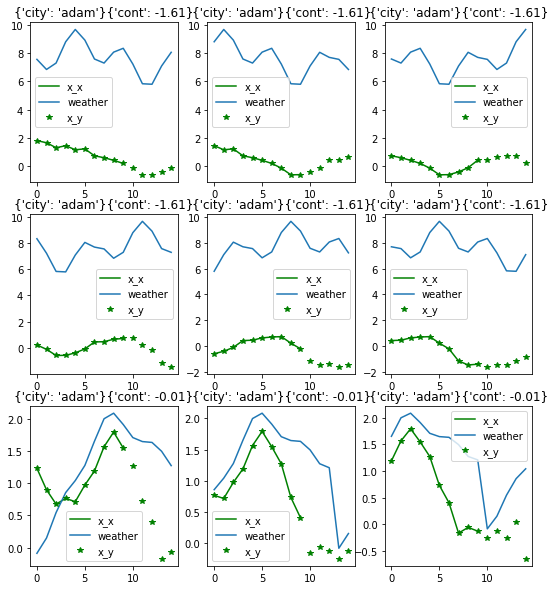

In [363]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

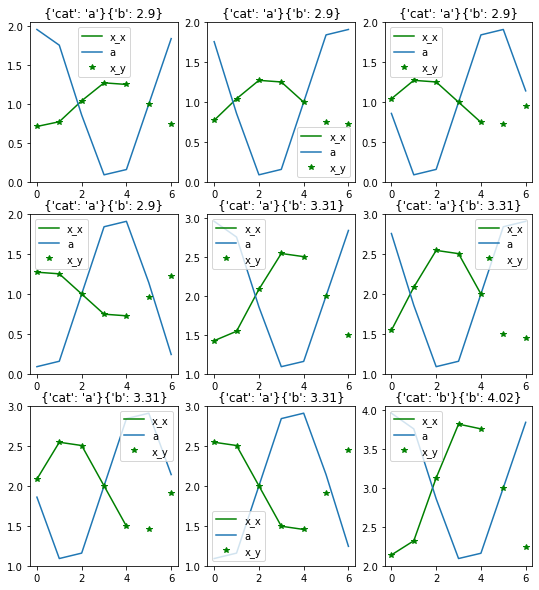

In [364]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [365]:
path = Path('../data/m5_tiny')
path.ls()

(#5) [Path('../data/m5_tiny/sales_train_validation.csv'),Path('../data/m5_tiny/sample_submission.csv'),Path('../data/m5_tiny/calendar.csv'),Path('../data/m5_tiny/sales_train_preped.csv'),Path('../data/m5_tiny/sell_prices.csv')]

In [366]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [367]:
def _to_series(df):
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:].values.astype(float)))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = pd.Series(_to_series(df))
    df = pd.DataFrame(data=data)
    return df
df_sales_s = to_contained_series(df_sales)

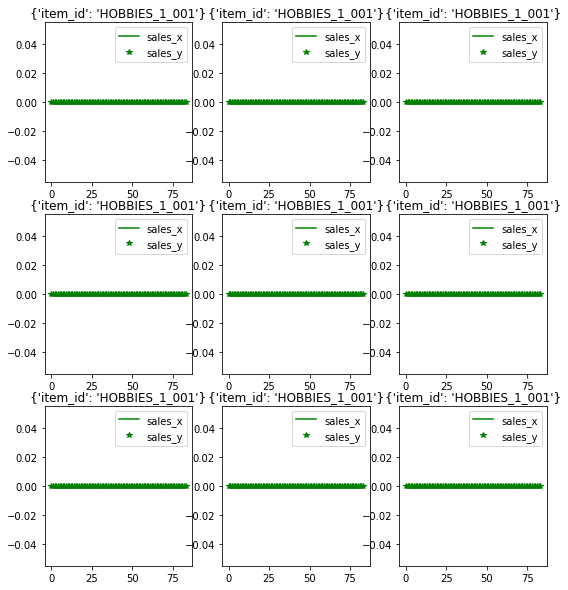

In [368]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
